# Action sequence analysis

This notebook generates the dataframes used for action sequences analyses, which are run in R.
It also generates plots along the way to compare structures, and contains visualizations of action sequences.


We calculate a few kinds of similarity between sequences. Raw and Transformed were used for the paper; temporal was dropped. 


In [22]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
proj_dir = os.path.abspath('../..')

if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))

import numpy as np
import scipy.stats as stats
import pandas as pd
from scipy.spatial import distance
from random import random
from sklearn.cluster import SpectralBiclustering
import itertools
from scipy.optimize import linear_sum_assignment

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib import colors

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import blockworld_helpers as utils
import drawing_utils as drawing
import importlib
import scoring
import rda

In [23]:
experiment_name = 'silhouette'

## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [24]:
stim_dir

'/home/wmccarth/block_construction/stimuli'

In [25]:
iteration_name = 'Exp2Pilot3_all'
num_trials = 24 #for sanity checks

In [26]:
# Data already compiled into dataframes in CogSci 2020 Dataframe Generator

# trial_end data
trial_path = os.path.join(csv_dir,'block_silhouette_{}_good.csv'.format(iteration_name))
df = pd.read_csv(trial_path)

# # initial_block data
initial_path = os.path.join(csv_dir,'block_silhouette_initial_{}_good.csv'.format(iteration_name))
dfi = pd.read_csv(initial_path)

# # settled_block data
settled_path = os.path.join(csv_dir,'block_silhouette_settled_{}_good.csv'.format(iteration_name))
dfs = pd.read_csv(settled_path)

# # Sanity Check- same participants in each dataset.
df_participants = df.gameID.unique()
dfs_participants = dfs.gameID.unique()
assert Counter(df_participants) == Counter(dfs_participants)

n_before_outliers = len(df_participants)
print(str(n_before_outliers) + ' participants total')

dfi['usableDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
dfi['flatDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: (1+(-1)*np.array(ast.literal_eval(a))).flatten())

105 participants total


# Visualization of build sequences

## Create Dataframe and Matrices

In [9]:
# Make action dataframe
dfa = dfi[['gameID','trialNum','targetName','repetition','blockNum','condition','phase_extended','y_index','x_index','width_discrete','height_discrete']]
dfa = dfa.rename(columns = {'y_index':'y',
                            'x_index':'x',
                            'width_discrete':'w',
                            'height_discrete':'h'})

targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())
extended_phases = ['pre', 'repetition 1', 'repetition 2', 'post']

## Experiment with one structure

In [10]:
# Choose which sequences to compare
truncating = True;

pptA = ppts[15]
targetA = targets[5]
phaseA = extended_phases[0]

pptB = ppts[15]
targetB = targets[5]
phaseB = extended_phases[3]

### Calculate distance matrix and visualize

In [13]:
# Calculate distance matrix

# select two sets of actions e.g. compare one ppts attempts at one structure pre to post
s1 = dfa[(dfa.gameID == pptA) & (dfa.targetName == targetA) & (dfa.phase_extended == phaseA)]
s2 = dfa[(dfa.gameID == pptB) & (dfa.targetName == targetB) & (dfa.phase_extended == phaseB)]

# truncate to length of smaller set of actions
n_actions = min(len(s1),len(s2))

if truncating:
    s1 = s1.iloc[0:n_actions]
    s2 = s2.iloc[0:n_actions]

# apply distance metric between each 4-tuple in the sequence (but append s1 to s2)
s1_s2 = s1.append(s2)

dist_mat = s1_s2.apply(lambda r: 
            s1_s2.apply(lambda r2: 
                distance.euclidean(r[['x','y','w','h']],r2[['x','y','w','h']]),
                axis=1),
            axis=1)

A: left, top, B: right, bottom


(0.0, 900.0, 0.0, 900.0)

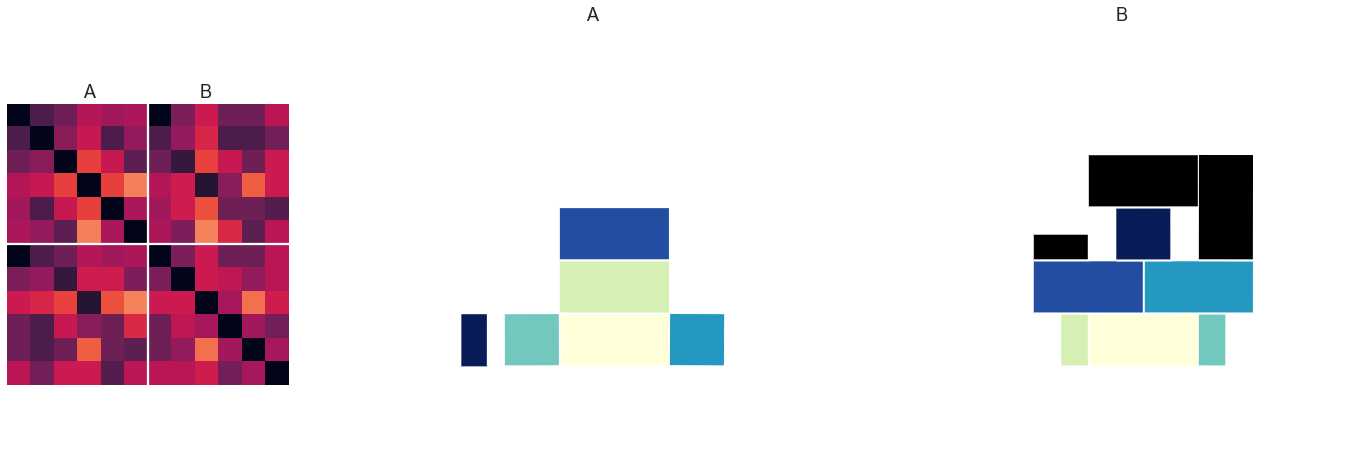

In [12]:
# Plot raw Euclidean distance matrix and reconstructions
# light --> dark : first --> last
# black : truncated i.e. not compared

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,8),
                       gridspec_kw={
                           'width_ratios': [1, 1.6, 1.6]})

ax[0].axis('off')
ax[0].imshow(dist_mat,vmin=0,vmax=10)
ax[0].axvline(x=(len(s1))-0.5, ymin=0, ymax=2*(len(s1))+1,color='white')
ax[0].axhline(y=(len(s1))-0.5, xmin=0, xmax=2*(len(s1))+1,color='white')
ax[0].set_title('A                     B')
print('A: left, top, B: right, bottom')

# fig2, ax2 = plt.subplots(figsize=(3,3))
drawing.draw_reconstruction_subplot(df=df[df.phase_extended == phaseA],gameID=pptA,targetName=targetA, ax=ax[1], n_colors = n_actions)
#draw_from_actions_subplot(dfa[(dfa.phase_extended == phaseA) & (dfa.gameID==pptA) & (dfa.targetName==targetA)], ax[1])
ax[1].set_title('A')
ax[1].axis('off')

# fig3, ax2 = plt.subplots(figsize=(3,3))
drawing.draw_reconstruction_subplot(df=df[df.phase_extended == phaseB],gameID=pptB,targetName=targetB, ax=ax[2], n_colors = n_actions)
# draw_from_actions_subplot(dfa[(dfa.phase_extended == phaseB) & (dfa.gameID==pptB) & (dfa.targetName==targetB)], ax[2])
ax[2].set_title('B')
ax[2].axis('off')

### Visualize Linear Sum Assignment (still working with one example from above)

This finds a mapping between two sequences that minimizes the total distances between each element.
It is being used here to find a 1-1 correspondence between block placements in two build sequences

In [15]:
# check displacements are equal in AB and BA case

AA = dist_mat.values[0:len(s1),0:len(s1)]
AB = dist_mat.values[len(s1):,0:len(s1)]
BA = dist_mat.values[0:len(s1),len(s1):]
BB = dist_mat.values[len(s1):,len(s1):]
 
sum_displacement_AB = sum(np.abs(np.arange(AB.shape[0]) - linear_sum_assignment(AB)[1]))
sum_displacement_BA = sum(np.abs(np.arange(BA.shape[0]) - linear_sum_assignment(BA)[1]))

print('Total displacement AB: ', sum_displacement_AB)
print('Total displacement BA: ', sum_displacement_BA)

Total displacement AB:  6
Total displacement BA:  6


Linear sum assignments can have multiple optimal assignments.
This is fine for optimal euclidean distance- as this is what the algorithm is minimizing.
It would cause an issue for temporal distance, as multiple rearrangements could have different size displacements.

Text(0.5, 1.0, 'AB_sorted')

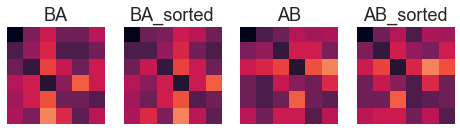

In [16]:
# Visualise the sort returned by linear_sum_assignment

AB_sorted = AB[:,linear_sum_assignment(AB)[1]]
BA_sorted = BA[:,linear_sum_assignment(BA)[1]]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8,2))

ax[0].axis('off')
ax[0].imshow(BA, vmin=0,vmax=10)
ax[0].set_title('BA')
ax[1].axis('off')
ax[1].imshow(BA_sorted, vmin=0,vmax=10) 
ax[1].set_title('BA_sorted')
ax[2].axis('off')
ax[2].imshow(AB, vmin=0,vmax=10)
ax[2].set_title('AB')
ax[3].axis('off')
ax[3].imshow(AB_sorted, vmin=0,vmax=10)
ax[3].set_title('AB_sorted')

In [173]:
# Scaled displacement

AA = dist_mat.values[0:len(s1),0:len(s1)]
AB = dist_mat.values[len(s1):,0:len(s1)]
BA = dist_mat.values[0:len(s1),len(s1):]
BB = dist_mat.values[len(s1):,len(s1):]


sum_displacement_AB = np.mean((np.abs(np.arange(AB.shape[0]) - linear_sum_assignment(AB)[1])/(len(AB))))
sum_displacement_BA = np.mean((np.abs(np.arange(BA.shape[0]) - linear_sum_assignment(BA)[1])/(len(BA))))

print('Total displacement AB: ', sum_displacement_AB)
print('Total displacement BA: ', sum_displacement_BA)

Total displacement AB:  0.16666666666666666
Total displacement BA:  0.16666666666666666


# Action sequence analysis- raw and transformed Euclidean

Here we find distances between action sequences. We explore 3 types of distances.

- Raw Euclidean: mean euclidean distance between corresponding actions
- Transformed Euclidean: minimized euclidean distance, when actions are allowed to rearrange
- Temporal: the degree to which the sequence has to be rearranged (mean displacement)

## Functions for applying any spatial distance metric, and any sequence/string distance metric

In [36]:
# Create a dataframe with columns: ppt, structure, from_phase, to_phase, distance

# 1. Define functions and useful arrays

# reps = np.sort(df['phase_extended'].unique())
# phase_pairs = list(itertools.combinations(reps,2))
targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())
extended_phases = ['pre', 'repetition 1', 'repetition 2', 'post']
all_phase_pairs = list(itertools.combinations(extended_phases,2))

                                            
def get_mean_displacement(distance_matrix):
    '''
    Takes a distance matrix, finds optimal mapping of rows, and returns the mean displacement of each action to achieve mapping

    '''
    displacements = (np.abs(np.arange(distance_matrix.shape[0]) - linear_sum_assignment(distance_matrix)[1])/distance_matrix.shape[0])
    mean_displacement = np.mean(displacements)
    return mean_displacement

def kendall_tau_distance(distance_matrix):
    '''
    Percent of pairs of indices that occur in a different order
    This metric ranges between -1 and 1, and is higher for more similar orders/strings
    '''
    kt = stats.kendalltau(np.arange(distance_matrix.shape[0]), linear_sum_assignment(distance_matrix)[1])[0]
    return kt

def get_distance_matrix(A,B,distance_measure=distance.euclidean, truncating = True):
    '''
    Returns distance matrix truncated to shortest sequence
    '''

    # truncate to length of smaller set of actions
    n_actions = min(len(A),len(B))

    if truncating:
        A = A.iloc[0:n_actions]
        B = B.iloc[0:n_actions]

    B_to_A = A.apply(lambda r: 
                B.apply(lambda r2: 
                    distance_measure(r[['x','y','w','h']], r2[['x','y','w','h']]),
                    axis=1),
                axis=1)

    return B_to_A

def get_phase_displacements(group, displacement_measure = get_mean_displacement, distance_measure=distance.euclidean):
    '''
    Group is a dataframe (usually groupby of targetName and gameID)
    displacement_measure calculates some temporal distance, or difference between sorts of action sequences
    distance_measure is the distance between action vectors [x,y,w,h]
    '''
    if group.phase_extended.nunique() == 2:
        phase_pairs = [('pre','post')]
    else:
        phase_pairs = all_phase_pairs

    phase_df = pd.DataFrame(phase_pairs,
                            columns=['phase_a','phase_b'])
        
    phase_df['temporal_distance'] = phase_df.apply(lambda r: displacement_measure(
                                            get_distance_matrix(\
                                                group[group.phase_extended==r.phase_a],\
                                                group[group.phase_extended==r.phase_b],\
                                                distance_measure)),                           
                                            axis=1)
    return phase_df

def get_aggregate_distances(group, distance_measure=distance.euclidean):
    '''
    Group is a dataframe (usually groupby of targetName and gameID)
    distance_measure is the distance between action vectors [x,y,w,h]
    '''
    if group.phase_extended.nunique() == 2:
        phase_pairs = [('pre','post')]
    else:
        phase_pairs = all_phase_pairs

    phase_df = pd.DataFrame(phase_pairs,
                            columns=['phase_a','phase_b'])
        
    phase_df['actual_euclidean_distance'] = phase_df.apply(lambda r: np.mean(\
                                            np.diag(\
                                                get_distance_matrix(\
                                                    group[group.phase_extended==r.phase_a],\
                                                    group[group.phase_extended==r.phase_b],\
                                                    distance_measure))),
                                         axis=1)
    return phase_df


def get_optimal_aggregate_distances(group, distance_measure=distance.euclidean):
    '''
    Group is a dataframe (usually groupby of targetName and gameID)
    distance_measure is the distance between action vectors [x,y,w,h]
    '''
    if group.phase_extended.nunique() == 2:
        phase_pairs = [('pre','post')]
    else:
        phase_pairs = all_phase_pairs

    phase_df = pd.DataFrame(phase_pairs,
                            columns=['phase_a','phase_b'])
        
    phase_df['optimal_euclidean_distance'] = phase_df.apply(lambda r:\
                                      np.mean(\
                                          np.diag(\
                                                optimal_sort(\
                                                #distance matrix sorted by optimal order    
                                                    get_distance_matrix(\
                                                        group[group.phase_extended==r.phase_a],\
                                                        group[group.phase_extended==r.phase_b],\
                                                        distance_measure).values))),

                                     axis=1)
    
    return phase_df

def optimal_sort(distance_matrix):
    optimal_assignment = linear_sum_assignment(distance_matrix)[1]
    sorted_matrix = distance_matrix[:, optimal_assignment]
    return sorted_matrix


def get_aggregate_distances_btw_ppts(df_structure, distance_measure=distance.euclidean):
    '''
    Group is a dataframe (usually groupby of targetName and gameID)
    distance_measure is the distance between action vectors [x,y,w,h]
    
    Returns the variance between participants for a given structure and phase
    '''
    
    #get OPTIMAL distance between two people
    
    phase_dists = df_structure.groupby('gameID').apply(lambda ppt_A:\
                df_structure.groupby('gameID').apply(lambda ppt_B:\
                                                      np.mean(\
                                                          np.diag(\
                                                            optimal_sort(\
                                                              get_distance_matrix(ppt_A, ppt_B).values)))))

    sum_sq_diffs = np.sum(np.triu(np.square(phase_dists)))
    var = sum_sq_diffs/(df_structure['gameID'].nunique()**2)
    
    return var

## Action sequence distance measures (Euclidean vs Raw)

In [212]:
# 2. Subset data
dfa = dfi[['gameID','trialNum','targetName','repetition','blockNum','condition','phase_extended','y_index','x_index','width_discrete','height_discrete']]
dfa = dfa.rename(columns = {'y_index':'y',
                            'x_index':'x',
                            'width_discrete':'w',
                            'height_discrete':'h'})


In [213]:
# Group by ppt and targetName, apply spatial-distance measure and aggregate by taking mean of the diagonal
df_optimal_euclidean_distances = dfa.groupby(['targetName','gameID'])\
        .apply(lambda x: get_optimal_aggregate_distances(x))\
        .reset_index()


# 4. Add phase-to-phase column
df_optimal_euclidean_distances['phase_pair'] = df_optimal_euclidean_distances.apply(\
            lambda row: row.phase_a + ' to ' + row.phase_b, axis = 1)

In [214]:
df_optimal_euclidean_distances

,targetName,gameID,level_2,phase_a,phase_b,optimal_euclidean_distance,phase_pair
0,hand_selected_004,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,pre,post,3.100925,pre to post
1,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,0,pre,repetition 1,0.844291,pre to repetition 1
2,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,1,pre,repetition 2,0.844291,pre to repetition 2
3,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,2,pre,post,0.936887,pre to post
4,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,3,repetition 1,repetition 2,0.000000,repetition 1 to repetition 2
...,...,...,...,...,...,...,...
1367,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,1,pre,repetition 2,0.000000,pre to repetition 2
1368,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,2,pre,post,1.746204,pre to post
1369,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,3,repetition 1,repetition 2,2.793158,repetition 1 to repetition 2
1370,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,4,repetition 1,post,1.320706,repetition 1 to post


/Users/will/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 864x1152 with 0 Axes>

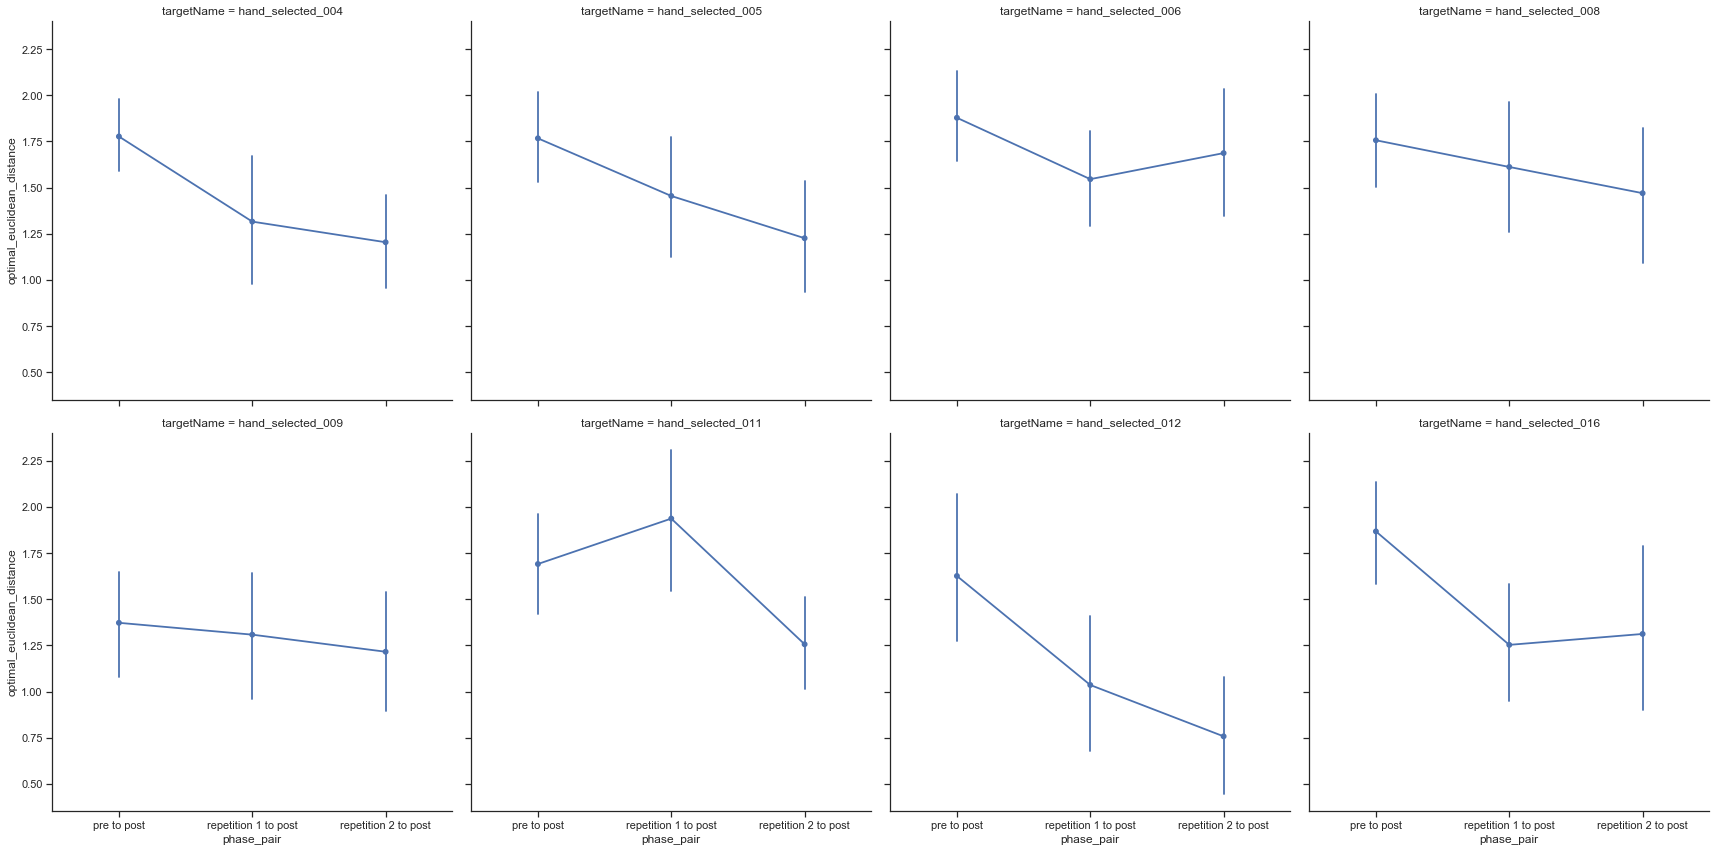

In [215]:
df_tmp = df_optimal_euclidean_distances[df_optimal_euclidean_distances.phase_pair.isin(['pre to post',
                                                                    'repetition 1 to post',
                                                                    'repetition 2 to post'])]

fig = plt.figure()
fig.set_size_inches(12, 16)
sns.set(style="ticks", rc={"lines.linewidth": 1})
g = sns.FacetGrid(df_tmp, col="targetName", col_wrap=4, height=6)
g.map(sns.pointplot, "phase_pair", "optimal_euclidean_distance")

In [216]:
df_euclidean_distances = dfa.groupby(['targetName','gameID'])\
        .apply(lambda x: get_aggregate_distances(x))\
        .reset_index()


# 4. Add phase-to-phase column
df_euclidean_distances['phase_pair'] = df_euclidean_distances.apply(\
            lambda row: row.phase_a + ' to ' + row.phase_b, axis = 1)

In [217]:
df_euclidean_distances

,targetName,gameID,level_2,phase_a,phase_b,actual_euclidean_distance,phase_pair
0,hand_selected_004,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,pre,post,5.088994,pre to post
1,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,0,pre,repetition 1,2.711420,pre to repetition 1
2,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,1,pre,repetition 2,2.490231,pre to repetition 2
3,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,2,pre,post,2.340887,pre to post
4,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,3,repetition 1,repetition 2,1.272144,repetition 1 to repetition 2
...,...,...,...,...,...,...,...
1367,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,1,pre,repetition 2,0.816497,pre to repetition 2
1368,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,2,pre,post,4.929865,pre to post
1369,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,3,repetition 1,repetition 2,4.572609,repetition 1 to repetition 2
1370,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,4,repetition 1,post,5.956067,repetition 1 to post


<Figure size 864x1152 with 0 Axes>

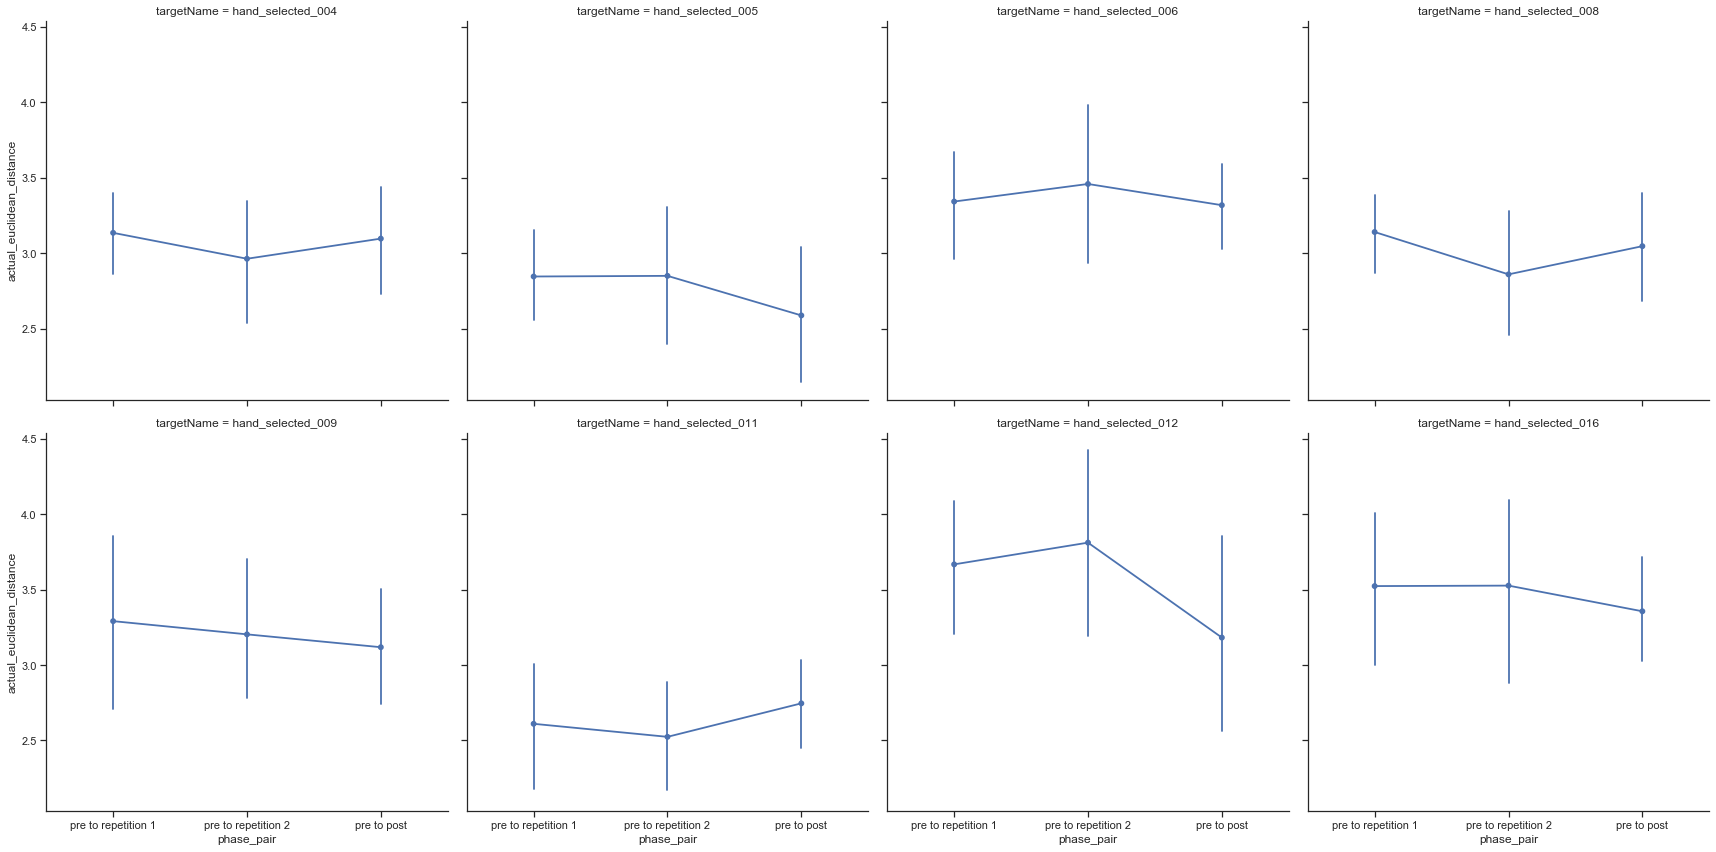

In [237]:
df_tmp = df_euclidean_distances[df_euclidean_distances.phase_pair.isin([
                                                                    'pre to repetition 1',
                                                                    'pre to repetition 2',
                                                                    'pre to post'])]


fig = plt.figure()
fig.set_size_inches(12, 16)
sns.set(style="ticks", rc={"lines.linewidth": 1})
g = sns.FacetGrid(df_tmp, col="targetName", col_wrap=4, height=6)
g.map(sns.pointplot, "phase_pair", "actual_euclidean_distance")

<Figure size 864x1152 with 0 Axes>

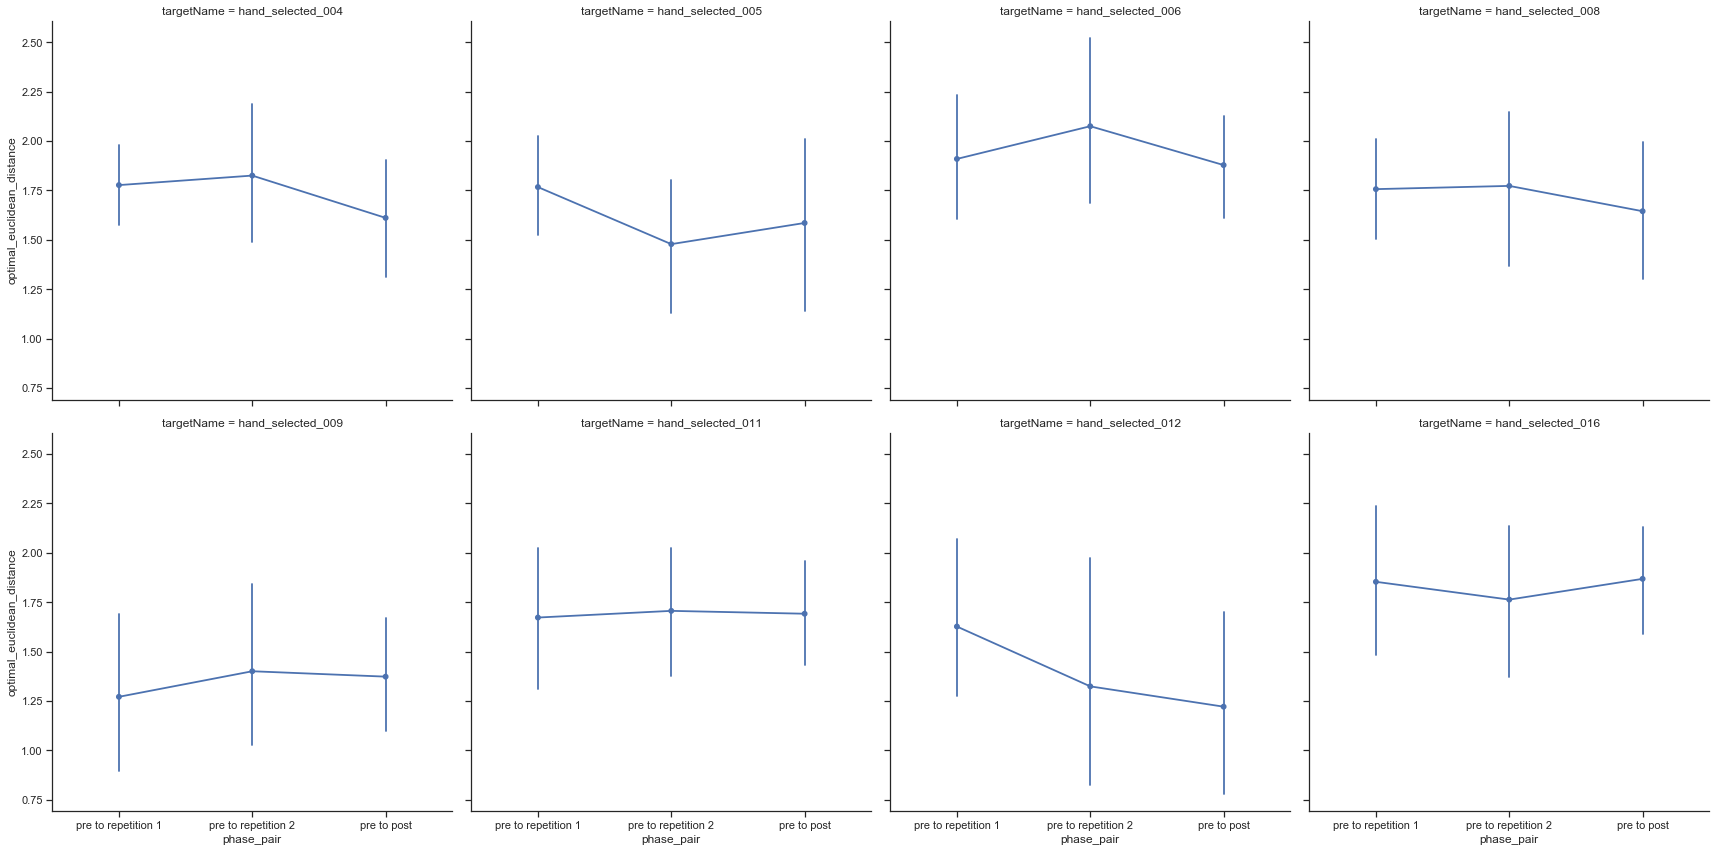

In [239]:
df_tmp = df_optimal_euclidean_distances[df_euclidean_distances.phase_pair.isin([
                                                                    'pre to repetition 1',
                                                                    'pre to repetition 2',
                                                                    'pre to post'])]


fig = plt.figure()
fig.set_size_inches(12, 16)
sns.set(style="ticks", rc={"lines.linewidth": 1})
g = sns.FacetGrid(df_tmp, col="targetName", col_wrap=4, height=6)
g.map(sns.pointplot, "phase_pair", "optimal_euclidean_distance")

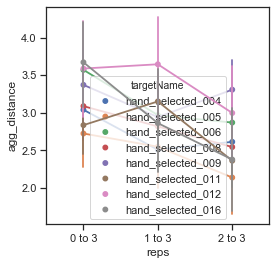

In [68]:
df_tmp = df_euclidean_distances[df_euclidean_distances.reps.isin(['0 to 3','1 to 3','2 to 3'])]

fig = plt.figure()
fig.set_size_inches(4, 4)
sns.set(style="ticks", rc={"lines.linewidth": 1})
sns.pointplot(data=df_tmp, x="reps", y="agg_distance", hue='targetName')

### Action sequence similarity- temporal- not used in paper

In [219]:
# 2. Subset data
dfa = dfi[['gameID','trialNum','targetName','repetition','blockNum','condition','phase_extended','y_index','x_index','width_discrete','height_discrete']]
dfa = dfa.rename(columns = {'y_index':'y',
                            'x_index':'x',
                            'width_discrete':'w',
                            'height_discrete':'h'})

In [220]:
# 3. Group by ppt and targetName, apply spatial-distance and time-displacement measures
df_temporal = dfa.groupby(['targetName','gameID']).apply(lambda x: get_phase_displacements(x, displacement_measure = kendall_tau_distance))\
                               .reset_index()

# 4. Add phase-to-phase column
df_temporal['phase_pair'] = df_temporal.apply(\
            lambda row: row.phase_a + ' to ' + row.phase_b, axis = 1)

<Figure size 864x1152 with 0 Axes>

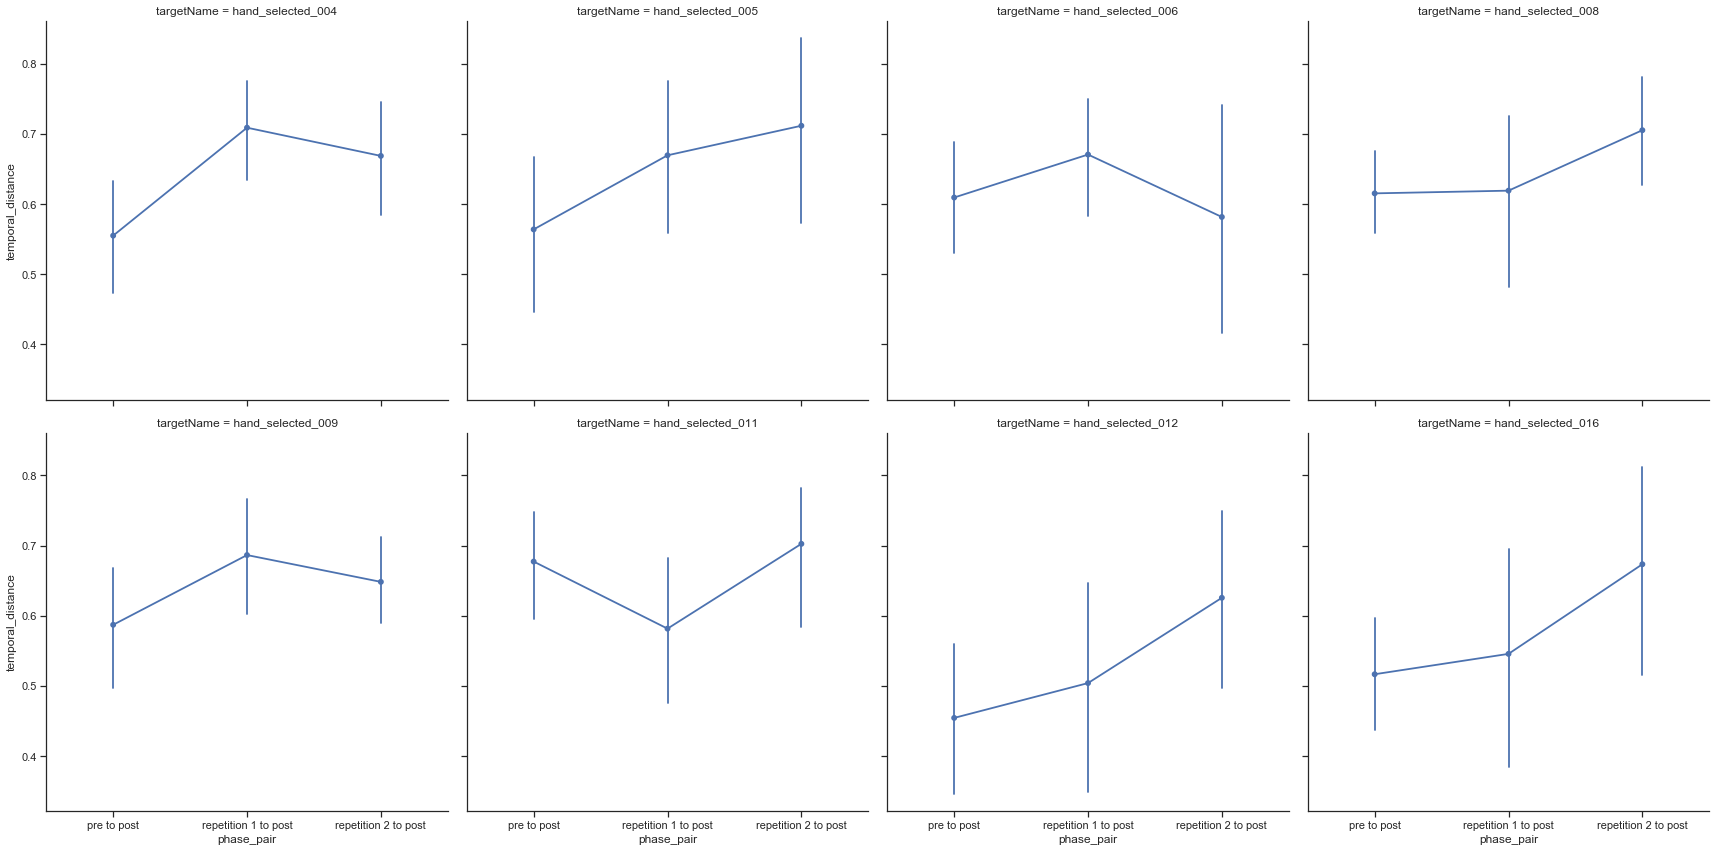

In [221]:
df_tmp = df_temporal[df_temporal.phase_pair.isin(['pre to post',
                                                    'repetition 1 to post',
                                                    'repetition 2 to post'])]


fig = plt.figure()
fig.set_size_inches(12, 16)
sns.set(style="ticks", rc={"lines.linewidth": 1})
g = sns.FacetGrid(df_tmp, col="targetName", col_wrap=4, height=6)
g.map(sns.pointplot, "phase_pair", "temporal_distance")

In [222]:
df_euclidean_distances

,targetName,gameID,level_2,phase_a,phase_b,actual_euclidean_distance,phase_pair
0,hand_selected_004,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,pre,post,5.088994,pre to post
1,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,0,pre,repetition 1,2.711420,pre to repetition 1
2,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,1,pre,repetition 2,2.490231,pre to repetition 2
3,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,2,pre,post,2.340887,pre to post
4,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,3,repetition 1,repetition 2,1.272144,repetition 1 to repetition 2
...,...,...,...,...,...,...,...
1367,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,1,pre,repetition 2,0.816497,pre to repetition 2
1368,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,2,pre,post,4.929865,pre to post
1369,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,3,repetition 1,repetition 2,4.572609,repetition 1 to repetition 2
1370,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,4,repetition 1,post,5.956067,repetition 1 to post


In [223]:
df_optimal_euclidean_distances

,targetName,gameID,level_2,phase_a,phase_b,optimal_euclidean_distance,phase_pair
0,hand_selected_004,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,pre,post,3.100925,pre to post
1,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,0,pre,repetition 1,0.844291,pre to repetition 1
2,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,1,pre,repetition 2,0.844291,pre to repetition 2
3,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,2,pre,post,0.936887,pre to post
4,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,3,repetition 1,repetition 2,0.000000,repetition 1 to repetition 2
...,...,...,...,...,...,...,...
1367,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,1,pre,repetition 2,0.000000,pre to repetition 2
1368,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,2,pre,post,1.746204,pre to post
1369,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,3,repetition 1,repetition 2,2.793158,repetition 1 to repetition 2
1370,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,4,repetition 1,post,1.320706,repetition 1 to post


In [224]:
df_temporal

,targetName,gameID,level_2,phase_a,phase_b,temporal_distance,phase_pair
0,hand_selected_004,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,pre,post,0.466667,pre to post
1,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,0,pre,repetition 1,0.418182,pre to repetition 1
2,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,1,pre,repetition 2,0.527273,pre to repetition 2
3,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,2,pre,post,0.757576,pre to post
4,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,3,repetition 1,repetition 2,0.890909,repetition 1 to repetition 2
...,...,...,...,...,...,...,...
1367,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,1,pre,repetition 2,0.866667,pre to repetition 2
1368,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,2,pre,post,-0.200000,pre to post
1369,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,3,repetition 1,repetition 2,0.238095,repetition 1 to repetition 2
1370,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,4,repetition 1,post,-0.222222,repetition 1 to post


In [225]:
df_euc = df_euclidean_distances.copy()
df_opt = df_optimal_euclidean_distances.copy()
df_time = df_temporal.copy()

In [115]:
# merge these three.
# add columns for accuracy, speed etc. in each rep

,targetName,gameID,level_2,rep_a,rep_b,actual_euclidean_distance,reps
0,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,0,0,1,2.711420,0 to 1
1,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,1,0,2,2.490231,0 to 2
2,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,2,0,3,2.340887,0 to 3
3,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,3,1,2,1.272144,1 to 2
4,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,4,1,3,2.222402,1 to 3
...,...,...,...,...,...,...,...
1171,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,1,0,2,0.816497,0 to 2
1172,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,2,0,3,4.929865,0 to 3
1173,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,3,1,2,4.572609,1 to 2
1174,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,4,1,3,5.956067,1 to 3


## Merge temporal, raw and transformed dataframes

In [226]:
df_out = df_euc.merge(df_opt, how='left').merge(df_time, how='left')
df_out

,targetName,gameID,level_2,phase_a,phase_b,actual_euclidean_distance,phase_pair,optimal_euclidean_distance,temporal_distance
0,hand_selected_004,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,pre,post,5.088994,pre to post,3.100925,0.466667
1,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,0,pre,repetition 1,2.711420,pre to repetition 1,0.844291,0.418182
2,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,1,pre,repetition 2,2.490231,pre to repetition 2,0.844291,0.527273
3,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,2,pre,post,2.340887,pre to post,0.936887,0.757576
4,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,3,repetition 1,repetition 2,1.272144,repetition 1 to repetition 2,0.000000,0.890909
...,...,...,...,...,...,...,...,...,...
1367,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,1,pre,repetition 2,0.816497,pre to repetition 2,0.000000,0.866667
1368,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,2,pre,post,4.929865,pre to post,1.746204,-0.200000
1369,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,3,repetition 1,repetition 2,4.572609,repetition 1 to repetition 2,2.793158,0.238095
1370,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,4,repetition 1,post,5.956067,repetition 1 to post,1.320706,-0.222222


<Figure size 864x1152 with 0 Axes>

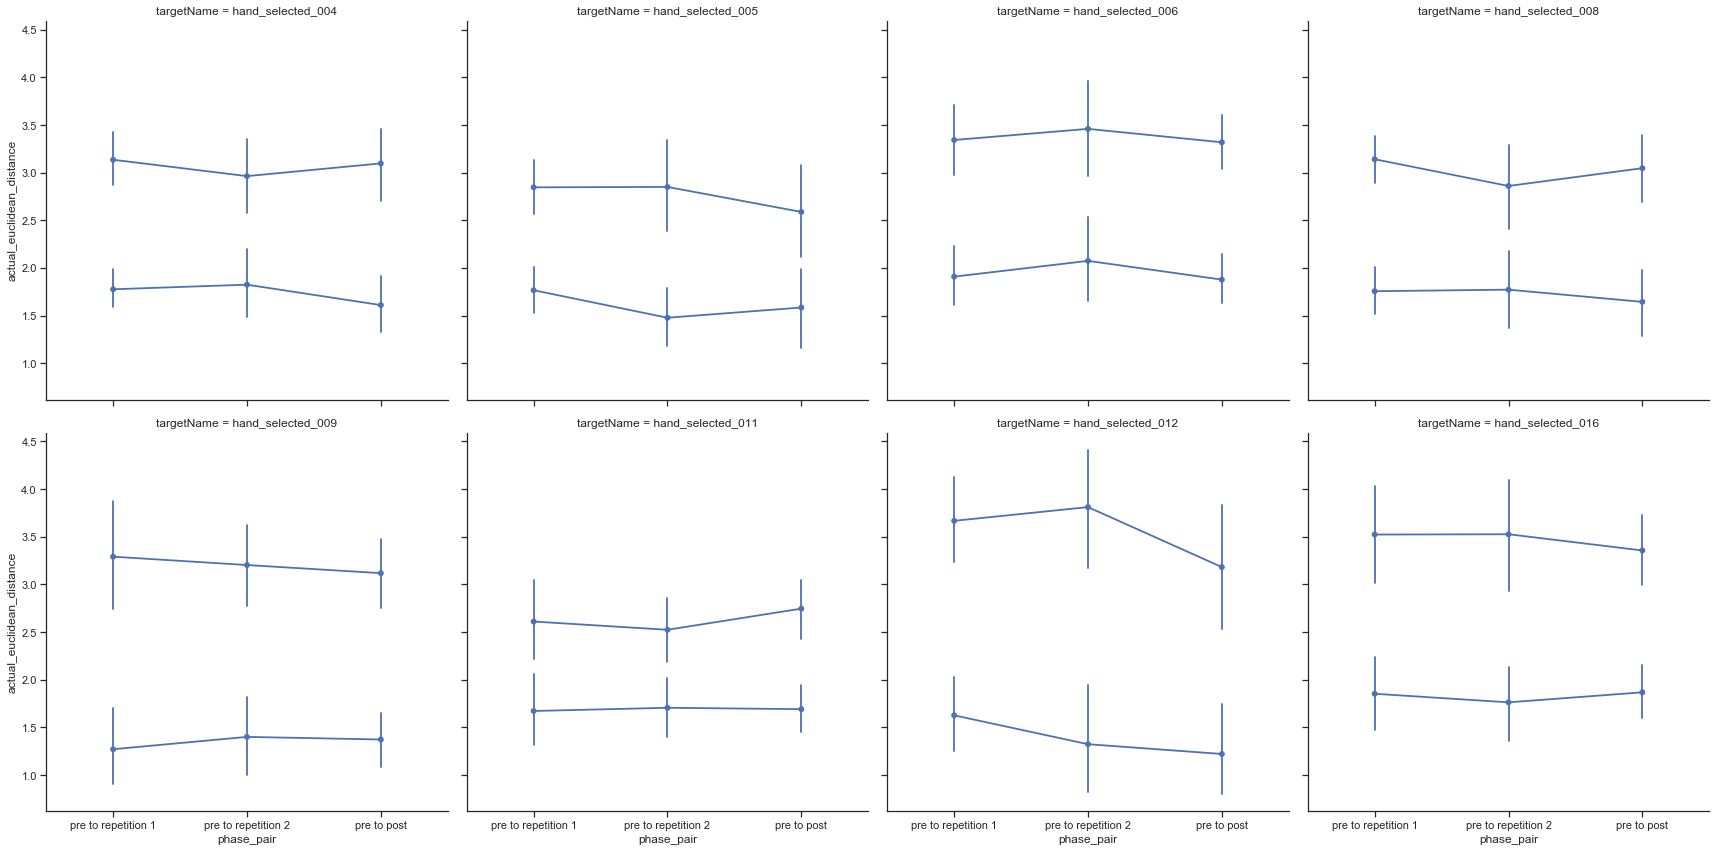

In [240]:
df_tmp = df_out[df_out.phase_pair.isin([
                                        'pre to repetition 1',
                                        'pre to repetition 2',
                                        'pre to post'])]


fig = plt.figure()
fig.set_size_inches(12, 16)
sns.set(style="ticks", rc={"lines.linewidth": 1})
g = sns.FacetGrid(df_tmp, col="targetName", col_wrap=4, height=6)
g.map(sns.pointplot, "phase_pair", "optimal_euclidean_distance")
g.map(sns.pointplot, "phase_pair", "actual_euclidean_distance")

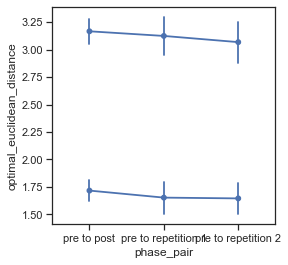

In [243]:
fig = plt.figure()
fig.set_size_inches(4, 4)
sns.set(style="ticks", rc={"lines.linewidth": 1})
sns.pointplot(data=df_tmp, x="phase_pair", y="actual_euclidean_distance")
sns.pointplot(data=df_tmp, x="phase_pair", y="optimal_euclidean_distance")


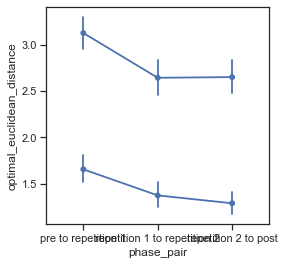

In [244]:
df_tmp = df_out[df_out.phase_pair.isin(['pre to repetition 1',
                                        'repetition 1 to repetition 2',
                                        'repetition 2 to post'])]
fig = plt.figure()
fig.set_size_inches(4, 4)
sns.set(style="ticks", rc={"lines.linewidth": 1})
sns.pointplot(data=df_tmp, x="phase_pair", y="actual_euclidean_distance")
sns.pointplot(data=df_tmp, x="phase_pair", y="optimal_euclidean_distance")


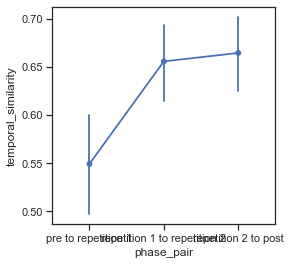

In [245]:
df_tmp = df_out[df_out.phase_pair.isin(['pre to repetition 1',
                                        'repetition 1 to repetition 2',
                                        'repetition 2 to post'])]
fig = plt.figure()
fig.set_size_inches(4, 4)
sns.set(style="ticks", rc={"lines.linewidth": 1})
sns.pointplot(data=df_tmp, x="phase_pair", y="temporal_similarity")


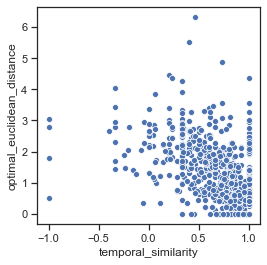

In [247]:
df_tmp = df_out[df_out.phase_pair.isin(['pre to repetition 1',
                                        'repetition 1 to repetition 2',
                                        'repetition 2 to post'])]
fig = plt.figure()
fig.set_size_inches(4, 4)
sns.set(style="ticks", rc={"lines.linewidth": 1})
sns.scatterplot(data=df_tmp, y="optimal_euclidean_distance", x="temporal_similarity")


### Add accuracy measures to dataframe for analyses in R

In [131]:
phases = ['pre', 'repetition 1', 'repetition 2', 'post']

In [228]:
df_out['phase_a_rawF1DiscreteScore'] = df_out.apply(lambda row: df[(df.targetName == row.targetName) &
                            (df.gameID == row.gameID) &
                            (df.phase_extended == row.phase_a)]['rawF1DiscreteScore'].values[0],
             axis = 1)

df_out['phase_b_rawF1DiscreteScore'] = df_out.apply(lambda row: df[(df.targetName == row.targetName) &
                            (df.gameID == row.gameID) &
                            (df.phase_extended == row.phase_b)]['rawF1DiscreteScore'].values[0],
             axis = 1)

df_out['condition'] = df_out.apply(lambda row: df[(df.targetName == row.targetName) &
                            (df.gameID == row.gameID)]['condition'].values[0], #haven't checked this line yet
             axis = 1)

In [233]:
df_out = df_out.rename(columns={"temporal_distance": "temporal_similarity"})
df_out

,targetName,gameID,level_2,phase_a,phase_b,actual_euclidean_distance,phase_pair,optimal_euclidean_distance,temporal_similarity,phase_a_rawF1DiscreteScore,phase_b_rawF1DiscreteScore,condition
0,hand_selected_004,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,pre,post,5.088994,pre to post,3.100925,0.466667,0.833333,0.500000,control
1,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,0,pre,repetition 1,2.711420,pre to repetition 1,0.844291,0.418182,0.945455,1.000000,repeated
2,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,1,pre,repetition 2,2.490231,pre to repetition 2,0.844291,0.527273,0.945455,1.000000,repeated
3,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,2,pre,post,2.340887,pre to post,0.936887,0.757576,0.945455,1.000000,repeated
4,hand_selected_004,0443-fd078367-c19d-495d-84d5-3519a281435d,3,repetition 1,repetition 2,1.272144,repetition 1 to repetition 2,0.000000,0.890909,1.000000,1.000000,repeated
...,...,...,...,...,...,...,...,...,...,...,...,...
1367,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,1,pre,repetition 2,0.816497,pre to repetition 2,0.000000,0.866667,0.657143,0.694444,repeated
1368,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,2,pre,post,4.929865,pre to post,1.746204,-0.200000,0.657143,0.755556,repeated
1369,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,3,repetition 1,repetition 2,4.572609,repetition 1 to repetition 2,2.793158,0.238095,0.750000,0.694444,repeated
1370,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,4,repetition 1,post,5.956067,repetition 1 to post,1.320706,-0.222222,0.750000,0.755556,repeated


In [235]:
#out_path = os.path.join(csv_dir,'block_silhouette_{}_rep_distances.csv'.format(iteration_name))
#df_out.to_csv(out_path)

## Variance Analyses

How does the variance in action sequences change from first to final attempt?
Calculated using transformed Euclidean distances

Dataframes created here, but analysed in R

### Separate for each condition (not used in paper)

In [ ]:
# Group by phase and targetName, apply spatial-distance measure and aggregate by taking mean of the diagonal

if False:
    df_ppt_variance_sep = dfa.groupby(['condition','targetName','phase_extended'])\
            .apply(lambda x: get_aggregate_distances_btw_ppts(x))\
            .reset_index()
    
    df_ppt_variance_sep = df_ppt_variance_sep.rename(index=str,columns={0:'variance'})
    
    out_path = os.path.join(csv_dir,'block_silhouette_{}_ppt_variance_separate.csv'.format(iteration_name))
    df_ppt_variance_sep.to_csv(out_path)

### Agent data

In [31]:
#Group by phase and targetName, apply spatial-distance measure and aggregate by taking mean of the diagonal
# read in one dataframe of 105 runs of agent on each structure

df_agent = pd.read_csv(os.path.join(csv_dir, 'agent_results/1000/block_silhouette_initial_random_agent_105_complete_0.csv'))
df_agent['gameID'] = df_agent['runID']
df_agent

,Unnamed: 0,targetName,run,runID,blockNum,discreteWorld,perfect,x,y,w,h,batch,rawF1DiscreteScore,gameID
0,0,hand_selected_004,0,a8dddbcc-9ad1-11ea-96f1-8b821aad575a,0,[[0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 ...,False,5,0,2,1,a8ddd910-9ad1-11ea-96f1-8b821aad575a,0.074074,a8dddbcc-9ad1-11ea-96f1-8b821aad575a
1,1,hand_selected_004,0,a8dddbcc-9ad1-11ea-96f1-8b821aad575a,1,[[0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 ...,False,10,0,2,4,a8ddd910-9ad1-11ea-96f1-8b821aad575a,0.322581,a8dddbcc-9ad1-11ea-96f1-8b821aad575a
2,2,hand_selected_004,0,a8dddbcc-9ad1-11ea-96f1-8b821aad575a,2,[[0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 ...,False,9,4,4,2,a8ddd910-9ad1-11ea-96f1-8b821aad575a,0.514286,a8dddbcc-9ad1-11ea-96f1-8b821aad575a
3,3,hand_selected_004,0,a8dddbcc-9ad1-11ea-96f1-8b821aad575a,3,[[0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 ...,False,8,6,4,2,a8ddd910-9ad1-11ea-96f1-8b821aad575a,0.666667,a8dddbcc-9ad1-11ea-96f1-8b821aad575a
4,4,hand_selected_004,0,a8dddbcc-9ad1-11ea-96f1-8b821aad575a,4,[[0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 ...,False,12,6,1,2,a8ddd910-9ad1-11ea-96f1-8b821aad575a,0.700000,a8dddbcc-9ad1-11ea-96f1-8b821aad575a
5,5,hand_selected_004,0,a8dddbcc-9ad1-11ea-96f1-8b821aad575a,5,[[0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 ...,False,7,0,2,4,a8ddd910-9ad1-11ea-96f1-8b821aad575a,0.818182,a8dddbcc-9ad1-11ea-96f1-8b821aad575a
6,6,hand_selected_004,0,a8dddbcc-9ad1-11ea-96f1-8b821aad575a,6,[[0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 ...,False,5,1,1,2,a8ddd910-9ad1-11ea-96f1-8b821aad575a,0.844444,a8dddbcc-9ad1-11ea-96f1-8b821aad575a
7,7,hand_selected_004,0,a8dddbcc-9ad1-11ea-96f1-8b821aad575a,7,[[0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 ...,False,7,4,2,1,a8ddd910-9ad1-11ea-96f1-8b821aad575a,0.869565,a8dddbcc-9ad1-11ea-96f1-8b821aad575a
8,8,hand_selected_004,0,a8dddbcc-9ad1-11ea-96f1-8b821aad575a,8,[[0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 ...,False,7,5,2,1,a8ddd910-9ad1-11ea-96f1-8b821aad575a,0.893617,a8dddbcc-9ad1-11ea-96f1-8b821aad575a
9,9,hand_selected_004,0,a8dddbcc-9ad1-11ea-96f1-8b821aad575a,9,[[0 0 0 0 0 0 0 0 0 0 0 0 0]\n [0 0 0 0 0 0 0 ...,False,7,6,1,2,a8ddd910-9ad1-11ea-96f1-8b821aad575a,0.916667,a8dddbcc-9ad1-11ea-96f1-8b821aad575a


In [37]:
df_agent_variance = df_agent.groupby(['targetName'])\
         .apply(lambda x: get_aggregate_distances_btw_ppts(x))\
         .reset_index()

In [39]:
df_agent_variance

,targetName,0
0,hand_selected_004,1.846116
1,hand_selected_005,1.920806
2,hand_selected_006,1.470897
3,hand_selected_008,1.780081
4,hand_selected_009,1.576895
5,hand_selected_011,1.397149
6,hand_selected_012,0.905286
7,hand_selected_016,1.128341


In [44]:
np.mean(df_agent_variance['variance'])

1.5031963116990195

In [40]:
df_agent_variance = df_agent_variance.rename(index=str,columns={0:'variance'})
out_path = os.path.join(csv_dir,'block_silhouette_{}_ppt_variance_agent.csv'.format(iteration_name))
df_agent_variance.to_csv(out_path)

### Human data

In [21]:
# Group by phase and targetName, apply spatial-distance measure and aggregate by taking mean of the diagonal

df_ppt_variance = dfa.groupby(['targetName','phase_extended'])\
        .apply(lambda x: get_aggregate_distances_btw_ppts(x))\
        .reset_index()

# df_ppt_variance = df_ppt_variance.rename(index=str,columns={0:'variance'})
# out_path = os.path.join(csv_dir,'block_silhouette_{}_ppt_variance.csv'.format(iteration_name))
# df_ppt_variance.to_csv(out_path)

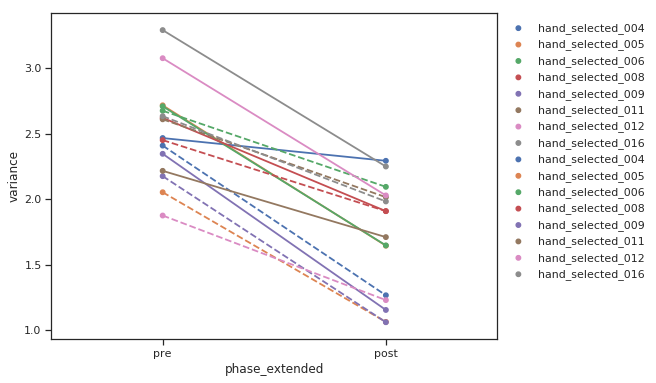

In [333]:
# broken down by condition

fig = plt.figure()
fig.set_size_inches(8, 6)
sns.set(style="ticks", rc={"lines.linewidth": 1,'legend.frameon':False})
sns.pointplot(data=df_ppt_variance_sep[df_ppt_variance_sep.condition=='control'], 
              x="phase_extended", 
              y="variance", 
              hue="targetName", 
              order=['pre','post'])
sns.pointplot(data=df_ppt_variance_sep[df_ppt_variance_sep.condition=='repeated'], 
              x="phase_extended", 
              y="variance", 
              hue="targetName", 
              linestyles=['--','--','--','--','--','--','--','--'],
              order=['pre','post'])
plt.legend(bbox_to_anchor=(1.0,1))

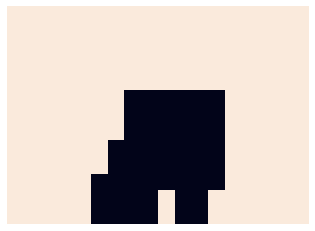

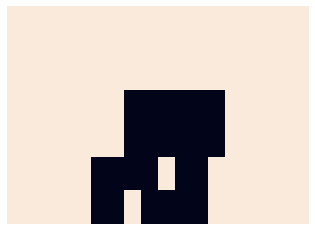

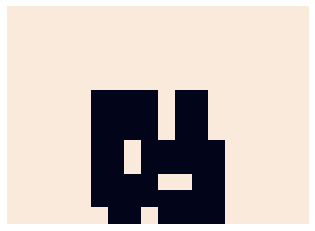

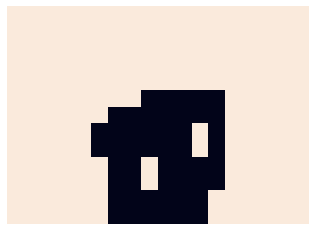

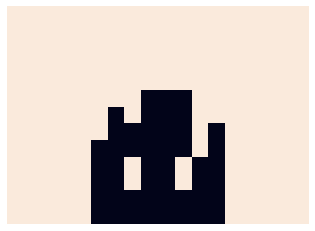

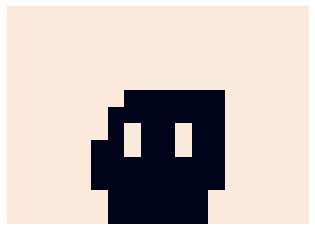

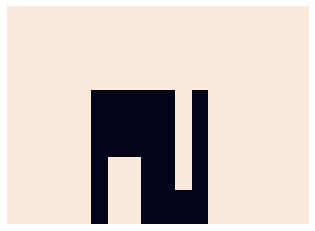

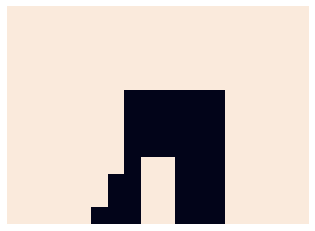

In [17]:
targets = np.sort(df['targetName'].unique())

for target_name in targets:
    silhouette = 1*np.logical_not(target_maps[target_name])
    silhouette = np.rot90(silhouette)
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(silhouette)

In [1]:
target_maps

NameError: name 'target_maps' is not defined

In [ ]:
# command to run large set of random agents

# python get_transformed_action_distance.py --in_path ../results/csv/agent_results/1000/block_silhouette_initial_random_agent_105_complete_0.csv --batch_dir ../results/csv/agent_action_batches --out_path ../results/csv/block_silhouette_Exp2Pilot3_transformedActionDistances_agent.csv



